In [1]:
# Объединение данных JPG & TIF (2017-07-03)

In [2]:
import sys,os,datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as skm
from __future__ import print_function

In [3]:
print(np.__version__);
print(pd.__version__);

1.12.1
0.19.2


In [4]:
import  cv2 as cv
cv.__version__

'3.2.0'

In [5]:
import xgboost as xgb

/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [6]:
sys.path.append('../Python')
from helper import paths_input, formImExt, formImHist
from estimate import confusion_matrix, getConfusion, getRocAUC, getProb01, getProbX01, getTh, estimateResult

In [7]:
binsData = 64

trLabels,trDirTIF,trDirJPG,teDirTIF,teDirJPG = paths_input()
trWork, teWork = '../Work/Train', '../Work/Test'
print (trWork, teWork)
print (trLabels,trDirTIF,trDirJPG,teDirTIF,teDirJPG)

../Work/Train ../Work/Test
../Data/train_v2.csv ../Data/train-tif-v2 ../Data/train-jpg ../Data/test-tif-v2 ../Data/test-jpg-v2


In [8]:
labels_df = pd.read_csv(trLabels)
labels_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [9]:
# Build list with unique labels
label_list = []
for tag_str in labels_df.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)

In [10]:
# Add features (0 or 1) for every label as dataframe field 
for label in label_list:
    labels_df[label] = labels_df['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)
#labels_df.head()

In [11]:
weather_labels = ['clear', 'partly_cloudy', 'haze', 'cloudy']
land_labels = ['primary', 'agriculture', 'water', 'cultivation', 'habitation' ]
rare_labels = [l for l in label_list if labels_df[label_list].sum()[l] < 2000]
#rare_labels              

In [12]:
labels = label_list; #weather_labels;
nameList =labels_df[labels_df[labels].sum(axis=1)>0].image_name.tolist(); len(nameList)
labelList=labels_df[labels_df[labels].sum(axis=1)>0][labels].as_matrix();
#labelList[:6,:]
#labels_df.head()

In [55]:
binsDataTIF = 256
binsDataJPG = 256

In [56]:
# Данные для объединения от jpg
##binsDataJPG2 = 64
trX_TIF  = np.load('../Data-XGB/Datas/train-'+str(10000+binsDataTIF)+'.tif'+'-XX.npy')
trX_JPG  = np.load('../Data-XGB/Datas/train-'+str(10000+binsDataJPG)+'.jpg'+'-XX.npy')
##trX_JPG2 = np.load('../Work/train-data-XX'+str(binsDataJPG2)+'.jpg'+'.npy')
trY      = np.load('../Data-XGB/Datas/train-'+str(10000+binsDataJPG)+'.jpg'+'-YY.npy')
trX_TIF.shape, trX_JPG.shape

((40479, 2048), (40479, 768))

In [57]:
# Обрезка
#cutting = 4
#trX_TIF = trX_TIF[:,64*cutting:]

In [58]:
##trX_TIF.shape, 290/3

In [59]:
##trXX = np.hstack([trX_JPG,trX_JPG2,trX_TIF])
trXX = np.hstack([trX_JPG,trX_TIF])
trX  = trXX
print (trX.shape,trX_TIF.shape,trX_JPG.shape,trY.shape)
##del trXX,trX_JPG,trX_TIF,trX_JPG2
del trXX,trX_JPG,trX_TIF

(40479, 2816) (40479, 2048) (40479, 768) (40479, 17)


In [60]:
# Строим основные массивы
dtrain = xgb.DMatrix(trX,label=trY[:,0])

In [61]:
# Построение списка bst - моделей
def getListBST (param, trX, trY, nfold=3, early_stop=20) :
    dtrain = xgb.DMatrix(trX,label=trY[:,0])
    results, bstList = [], []
    for i in range(trY.shape[1]) :
        print ('Working: {}'.format(i))
        dtrain.set_label(trY[:,i])
        history = xgb.cv(param, dtrain, metrics=['auc'], 
                         verbose_eval=30, num_boost_round=5000, nfold=nfold, 
                         early_stopping_rounds=early_stop)
        results.append(history)
        rvalidCV, watchlistCV = {}, [(dtrain,'train')]
        bst = xgb.train(param, dtrain, history['test-auc-mean'].argmax()+1, watchlistCV) 
        bstList.append(bst)
    return(bstList)

# Построение решения по dmatrix и bst списку
def buildPredict (dData, bstList) :
    trYP = []
    for bstI in bstList :
        trYP1 = bstI.predict(dData); trYP.append(trYP1)
    trYP = np.array(trYP).T
    #type(trYP),trYP.shape
    return(trYP)

# Построение решения по np.array (DataFrame?) и bst списку
def buildPredictX (Data, bstList) :
    dData = xgb.DMatrix(Data);
    return (buildPredict(dData,bstList))

In [62]:
param = {
         'objective':'reg:logistic', 
         #'num_class':17,
         #'eta':0.05, 
         #'max_depth':9, 'subsample':0.8, 'colsample_bytree':0.8, 
         #'metrics':'rmse'
         'eval_metric':['auc','rmse']
        }
param['silent']=True

In [129]:
# Считаем
print(datetime.datetime.now(),'Begin')
bstList = getListBST(param,trX,trY)
print(datetime.datetime.now(),'End')

2017-07-09 05:01:46.426997 Begin
Working: 0
[0]	train-auc:0.944635+0.000577445	test-auc:0.927645+0.00512275
[30]	train-auc:0.993011+0.000658158	test-auc:0.961744+0.00169165
[60]	train-auc:0.998284+0.000343195	test-auc:0.96174+0.00180916
[0]	train-auc:0.94249	train-rmse:0.378847
[1]	train-auc:0.955871	train-rmse:0.300054
[2]	train-auc:0.961681	train-rmse:0.249208
[3]	train-auc:0.96413	train-rmse:0.216485
[4]	train-auc:0.9676	train-rmse:0.196364
[5]	train-auc:0.969002	train-rmse:0.183544
[6]	train-auc:0.971182	train-rmse:0.175268
[7]	train-auc:0.973429	train-rmse:0.170265
[8]	train-auc:0.975263	train-rmse:0.166894
[9]	train-auc:0.976754	train-rmse:0.164163
[10]	train-auc:0.978061	train-rmse:0.162041
[11]	train-auc:0.979267	train-rmse:0.160316
[12]	train-auc:0.980857	train-rmse:0.159008
[13]	train-auc:0.981363	train-rmse:0.158191
[14]	train-auc:0.98201	train-rmse:0.156931
[15]	train-auc:0.983243	train-rmse:0.155195
[16]	train-auc:0.984281	train-rmse:0.154171
[17]	train-auc:0.98459	train-r

In [64]:
# Шаблоны имен файллов для сохранения моделей xgb
fModel1 = '../Data-XGB/Models/model-'
fModel2 = '-jpg'+str(binsDataJPG)+'-tif'+str(binsDataTIF)+'.xgb'

In [133]:
# save xgb models into files
for i in range(len(bstList)) :
    ##bstList[i].save_model(fModel1+str(100+i)+'-JPG2'+fModel2)
    bstList[i].save_model(fModel1+str(100+i)+fModel2)

In [65]:
# load xgb models into files
bstNull = xgb.train(param,dtrain,0)
bstList0= []
for i in range(trY.shape[1]) :
    bstList0.append(bstNull.copy())
    bstList0[-1].load_model(fModel1+str(100+i)+fModel2)
bstList = bstList0
del bstList0
len(bstList)

17

In [66]:
#
#  Построение решения для train массива на основе уровней прохождения (эффект почему-то дают)
#    Построенное решение 01 полное с учетом погодных критериев [0,3,9,10]
#        и особенности критерия cloudy (посмотреть и сменить можно в getProbX01)
#        Построение критериев прохождения в getTh
#

# train
trYP    = buildPredict(dtrain,bstList)

# Уровни прохождения & решение
trPPP,_ = getTh (trY,trYP)
trY01    = getProbX01(trYP,trPPP)
#trYP[0],trY01,trPPP

In [67]:
trYP[0],trY01[0],trY[0] #trPPP

(array([  7.52698421e-01,   9.95011568e-01,   1.22752870e-04,
          7.73504525e-02,   1.30947465e-02,   2.87400605e-03,
          1.06708594e-02,   4.35077073e-03,   5.12909202e-04,
          6.33149975e-05,   2.46757027e-05,   1.08422128e-05,
          1.10333401e-03,   2.58641933e-07,   4.88861697e-04,
          6.95545925e-04,   3.40726801e-05], dtype=float32),
 array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8),
 array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [71]:
if True : # LB=0.87170 jpg256+tif256
    np.save('../Work/Join-XGB-NET/XGB-jpg256-tif256-LB=0x87170/trIP01-XX.npy',trY01)
    np.save('../Work/Join-XGB-NET/XGB-jpg256-tif256-LB=0x87170/trIP-XX.npy', trYP)
    np.save('../Work/Join-XGB-NET/XGB-jpg256-tif256-LB=0x87170/trIY-YY.npy',trY)
    fModel1 = '../Work/Join-XGB-NET/XGB-jpg256-tif256-LB=0x87170/model-'
    fModel2 = '-jpg'+str(binsDataJPG)+'-tif'+str(binsDataTIF)+'.xgb'
    # save xgb models into files
    for i in range(len(bstList)) :
        ##bstList[i].save_model(fModel1+str(100+i)+'-JPG2'+fModel2)
        bstList[i].save_model(fModel1+str(100+i)+fModel2)

In [68]:
# jpg256+tif256-evi2-savi
temp = estimateResult(trY,trY01,printOK=True)

0 acc=0.99137824551 roc=0.94941538334 not=349 yes=2430 no=37700 true=40130 all-1-0=(0.9010-0.9978)
1 acc=0.990933570493 roc=0.973063076052 not=367 yes=37288 no=2824 true=40112 all-1-0=(0.9940-0.9521)
2 acc=0.997282541565 roc=0.996493506538 not=110 yes=12247 no=28122 true=40369 all-1-0=(0.9945-0.9985)
3 acc=0.991427653845 roc=0.987560236175 not=347 yes=28349 no=11783 true=40132 all-1-0=(0.9971-0.9780)
4 acc=0.936411472615 roc=0.870781760827 not=2574 yes=5686 no=32219 true=37905 all-1-0=(0.7672-0.9743)
5 acc=0.977148644976 roc=0.934165661528 not=925 yes=3227 no=36327 true=39554 all-1-0=(0.8817-0.9866)
6 acc=0.941574643642 roc=0.90177753085 not=2365 yes=6744 no=31370 true=38114 all-1-0=(0.8356-0.9680)
7 acc=0.94888707725 roc=0.847556312392 not=2069 yes=3212 no=35198 true=38410 all-1-0=(0.7174-0.9777)
8 acc=0.998493045777 roc=0.899285623477 not=61 yes=167 no=40251 true=40418 all-1-0=(0.7990-0.9995)
9 acc=0.999728254156 roc=0.998951434541 not=11 yes=2085 no=38383 true=40468 all-1-0=(0.9981-

In [27]:
# jpg256+tif256-evi2-savi
temp = estimateResult(trY,trY01,printOK=True)

0 acc=0.99137824551 roc=0.94941538334 not=349 yes=2430 no=37700 true=40130 all-1-0=(0.9010-0.9978)
1 acc=0.990933570493 roc=0.973063076052 not=367 yes=37288 no=2824 true=40112 all-1-0=(0.9940-0.9521)
2 acc=0.997282541565 roc=0.996493506538 not=110 yes=12247 no=28122 true=40369 all-1-0=(0.9945-0.9985)
3 acc=0.991427653845 roc=0.987560236175 not=347 yes=28349 no=11783 true=40132 all-1-0=(0.9971-0.9780)
4 acc=0.936411472615 roc=0.870781760827 not=2574 yes=5686 no=32219 true=37905 all-1-0=(0.7672-0.9743)
5 acc=0.977148644976 roc=0.934165661528 not=925 yes=3227 no=36327 true=39554 all-1-0=(0.8817-0.9866)
6 acc=0.941574643642 roc=0.90177753085 not=2365 yes=6744 no=31370 true=38114 all-1-0=(0.8356-0.9680)
7 acc=0.94888707725 roc=0.847556312392 not=2069 yes=3212 no=35198 true=38410 all-1-0=(0.7174-0.9777)
8 acc=0.998493045777 roc=0.899285623477 not=61 yes=167 no=40251 true=40418 all-1-0=(0.7990-0.9995)
9 acc=0.999728254156 roc=0.998951434541 not=11 yes=2085 no=38383 true=40468 all-1-0=(0.9981-

In [92]:
# jpg64+tif64+evi2+savi-r-b-g-n only jpg rgn+v.indexes
temp = estimateResult(trY,trY01,printOK=True)

0 acc=0.992761678895 roc=0.956354141954 not=293 yes=2466 no=37720 true=40186 all-1-0=(0.9143-0.9984)
1 acc=0.998888312458 roc=0.99862396545 not=45 yes=37473 no=2961 true=40434 all-1-0=(0.9989-0.9983)
2 acc=0.967612836285 roc=0.959932523288 not=1311 yes=11580 no=27588 true=39168 all-1-0=(0.9403-0.9795)
3 acc=0.994095703945 roc=0.991133567275 not=239 yes=28387 no=11853 true=40240 all-1-0=(0.9985-0.9838)
4 acc=0.929840164036 roc=0.841057407709 not=2840 yes=5195 no=32444 true=37639 all-1-0=(0.7010-0.9811)
5 acc=0.97218310729 roc=0.900185945068 not=1126 yes=2973 no=36380 true=39353 all-1-0=(0.8123-0.9881)
6 acc=0.933916351689 roc=0.88876038438 not=2675 yes=6567 no=31237 true=37804 all-1-0=(0.8137-0.9639)
7 acc=0.941821685318 roc=0.821482909203 not=2355 yes=2986 no=35138 true=38124 all-1-0=(0.6670-0.9760)
8 acc=0.998863608291 roc=0.913751436179 not=46 yes=173 no=40260 true=40433 all-1-0=(0.8278-0.9998)
9 acc=0.998616566615 roc=0.994744148482 not=56 yes=2069 no=38354 true=40423 all-1-0=(0.990

In [59]:
# jpg64+tif64+evi2+savi-r-b-g
temp = estimateResult(trY,trY01,printOK=True)

0 acc=0.996195558191 roc=0.974376434117 not=154 yes=2560 no=37765 true=40325 all-1-0=(0.9492-0.9996)
1 acc=0.996566120705 roc=0.990229635655 not=139 yes=37425 no=2915 true=40340 all-1-0=(0.9977-0.9828)
2 acc=0.976382815781 roc=0.973660408386 not=956 yes=11905 no=27618 true=39523 all-1-0=(0.9667-0.9806)
3 acc=0.996294374861 roc=0.994181442252 not=150 yes=28414 no=11915 true=40329 all-1-0=(0.9994-0.9890)
4 acc=0.928506138986 roc=0.842544172868 not=2894 yes=5239 no=32346 true=37585 all-1-0=(0.7069-0.9782)
5 acc=0.958249956768 roc=0.851065046156 not=1690 yes=2636 no=36153 true=38789 all-1-0=(0.7202-0.9819)
6 acc=0.927913238963 roc=0.885523051007 not=2918 yes=6578 no=30983 true=37561 all-1-0=(0.8150-0.9560)
7 acc=0.959608685985 roc=0.891234373138 not=1635 yes=3597 no=35247 true=38844 all-1-0=(0.8034-0.9790)
8 acc=0.999777662492 roc=0.990368541056 not=9 yes=205 no=40265 true=40470 all-1-0=(0.9809-0.9999)
9 acc=0.999925887497 roc=0.999960927325 not=3 yes=2089 no=38387 true=40476 all-1-0=(1.00

In [26]:
# jpg64+tif64+evi2+savi
temp = estimateResult(trY,trY01,printOK=True)

0 acc=0.987252649522 roc=0.927235082429 not=516 yes=2314 no=37649 true=39963 all-1-0=(0.8580-0.9965)
1 acc=0.995429728995 roc=0.988064029914 not=185 yes=37389 no=2905 true=40294 all-1-0=(0.9967-0.9794)
2 acc=0.980137849255 roc=0.97617610685 not=804 yes=11897 no=27778 true=39675 all-1-0=(0.9661-0.9863)
3 acc=0.987450282863 roc=0.98209825483 not=508 yes=28298 no=11673 true=39971 all-1-0=(0.9953-0.9689)
4 acc=0.935892685096 roc=0.865595969718 not=2595 yes=5593 no=32291 true=37884 all-1-0=(0.7547-0.9765)
5 acc=0.964722448677 roc=0.877260893899 not=1428 yes=2820 no=36231 true=39051 all-1-0=(0.7705-0.9840)
6 acc=0.970280886386 roc=0.953805757734 not=1203 yes=7477 no=31799 true=39276 all-1-0=(0.9264-0.9812)
7 acc=0.935200968403 roc=0.810035182569 not=2623 yes=2907 no=34949 true=37856 all-1-0=(0.6493-0.9708)
8 acc=0.999827070827 roc=0.992773301744 not=7 yes=206 no=40266 true=40472 all-1-0=(0.9856-0.9999)
9 acc=0.999505916648 roc=0.99860789177 not=20 yes=2084 no=38375 true=40459 all-1-0=(0.9976

In [34]:
# jpg64+tif64-evi2-savi
temp = estimateResult(trY,trY01,printOK=True)

0 acc=0.985078682774 roc=0.914535963562 not=604 yes=2247 no=37628 true=39875 all-1-0=(0.8331-0.9959)
1 acc=0.98861137874 roc=0.965755485727 not=461 yes=37233 no=2785 true=40018 all-1-0=(0.9925-0.9390)
2 acc=0.968724523827 roc=0.964615530127 not=1266 yes=11750 no=27463 true=39213 all-1-0=(0.9541-0.9751)
3 acc=0.983497616048 roc=0.976247318068 not=668 yes=28265 no=11546 true=39811 all-1-0=(0.9942-0.9583)
4 acc=0.945280268781 roc=0.884376088937 not=2215 yes=5842 no=32422 true=38264 all-1-0=(0.7883-0.9805)
5 acc=0.970429111391 roc=0.898729640657 not=1197 yes=2969 no=36313 true=39282 all-1-0=(0.8112-0.9863)
6 acc=0.932508214136 roc=0.882996172102 not=2732 yes=6462 no=31285 true=37747 all-1-0=(0.8006-0.9653)
7 acc=0.958496998444 roc=0.888653531608 not=1680 yes=3577 no=35222 true=38799 all-1-0=(0.7990-0.9783)
8 acc=0.999925887497 roc=0.992822966507 not=3 yes=206 no=40270 true=40476 all-1-0=(0.9856-1.0000)
9 acc=0.997875441587 roc=0.992542823764 not=86 yes=2061 no=38332 true=40393 all-1-0=(0.9

In [138]:
len(ttemps)

4

In [139]:
# Построение значимости полей для разных признаков (importance)
bstga   = np.zeros((trX.shape[1],trY.shape[1]))
for i in range(len(bstList)) :
    bstgfs = bstList[i].get_fscore()
    bstgfs = [(int(n.split('f')[1]),bstgfs[n]) for n in bstgfs.keys()]
    bstga1 = np.array(bstgfs)
    bstga[bstga1[:,0],i] = bstga1[:,1]


if False :
    #bstgfs.sort(key=lambda x: -x[1])
    #bstgfs[:20]
    plt.hist([nn for n,nn in bstgfs],bins=11); plt.show()
    bst_gfs_main = [(n,nn) for n,nn in bstgfs if nn>=20]
    bst_gfs_main.sort(key=lambda x: x[0])
    bst_gfs_main
    bstga[:,6]

In [140]:
temp[0]

array([  0.00000000e+00,   4.04790000e+04,   9.92119371e-01,
         9.54288489e-01,   2.69700000e+03,   3.77820000e+04,
         2.45600000e+03,   3.77040000e+04,   3.19000000e+02])

In [343]:
temp=ttemps[-1]

[4]


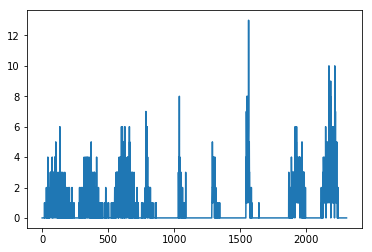

['water']

In [348]:
xx = [int(x[0]) for x in temp if x[8]>=1000] # плохие lost >=1000
xx = [4]
print(xx)
plt.plot(bstga[:,xx]); 
#plt.legenda([labels[x] for x in xx])
plt.show();
[labels[x] for x in xx]


[0, 1, 3, 5, 12, 15]


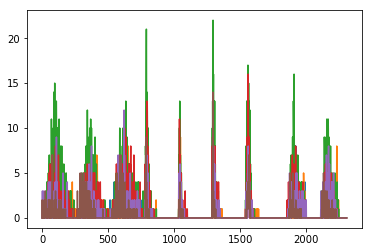

['haze', 'primary', 'clear', 'habitation', 'bare_ground', 'selective_logging']

In [143]:
xx = [int(x[0]) for x in temp if x[8]<1000 and x[8]>100] # среднии lost <=1000
print(xx)

plt.plot(bstga[:,xx]); 
#plt.legenda([labels[x] for x in xx])
plt.show();
[labels[x] for x in xx]


[2, 8, 9, 10, 11, 13, 14, 16]


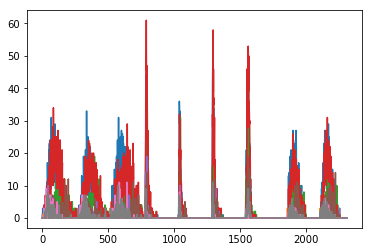

['agriculture',
 'slash_burn',
 'cloudy',
 'partly_cloudy',
 'conventional_mine',
 'artisinal_mine',
 'blooming',
 'blow_down']

In [145]:
xx = [int(x[0]) for x in temp if x[8]<=100] # хорошие lost <=100
print(xx)
plt.plot(bstga[:,xx]); plt.show();
[labels[x] for x in xx]

In [100]:
del trX

In [72]:
# Данные для объединения от jpg
##trOX_JPG1 = np.load('../Work/test-data-XX'+str(binsDataJPG)+'.jpg'+'.npy')
##trOX_JPG2 = np.load('../Work/test-data-XX'+str(binsDataJPG2)+'.jpg'+'.npy')
#trOY_JPG1 = np.load('../Work/test-data-YY'+str(binsDataJPG)+'.jpg'+'.npy')
#trOY_JPG2 = np.load('../Work/test-data-YY'+str(binsDataJPG2)+'.jpg'+'.npy')
trOX_JPG  = np.load('../Data-XGB/Datas/test-'+str(10000+binsDataJPG)+'.jpg'+'-XX.npy')
trOX_TIF  = np.load('../Data-XGB/Datas/test-'+str(10000+binsDataTIF)+'.tif'+'-XX.npy')
trOY_TIF  = np.load('../Data-XGB/Datas/test-'+str(10000+binsDataTIF)+'.tif'+'-YY.npy')
trOY_JPG  = np.load('../Data-XGB/Datas/test-'+str(10000+binsDataJPG)+'.jpg'+'-YY.npy')

In [73]:
#trOX_TIF.shape, trOX_JPG.shape, trOX_JPG2.shape , 578+255+192
trOX_TIF.shape, trOX_JPG.shape

((61191, 2048), (61191, 768))

In [74]:
# Обрезка видимой части и использование только n, ndvi, ndwi, evi2, savi
#trOX_TIF = trOX_TIF[:,64*cutting:]
##trOX_TIF.shape

In [75]:
# Аккуратно объединяем через индексы = имена файлов
##dfOX_JPG1 = pd.DataFrame(trOX_JPG,index=trOY_JPG1)
##dfOX_JPG2 = pd.DataFrame(trOX_JPG2,index=trOY_JPG2)
##dfOX_JPG  = dfOX_JPG1.join(dfOX_JPG2,lsuffix='_l',rsuffix='_r')

dfOX_TIF  = pd.DataFrame(trOX_TIF,index=trOY_TIF)
dfOX_JPG  = pd.DataFrame(trOX_JPG,index=trOY_JPG)
dfOX      = dfOX_JPG.join(dfOX_TIF,lsuffix='_l',rsuffix='_r')

dfOX.shape #, dfOX.columns,dfOX.head()

(61191, 2816)

In [76]:
trOX = dfOX.values
trOY = dfOX.index.values
trOX.shape,trOY.shape,trOY[0:10]

((61191, 2816),
 (61191,),
 array(['test_10002', 'test_10003', 'test_10004', 'test_10005',
        'test_10006', 'test_10007', 'test_10008', 'test_10009', 'test_1001',
        'test_10010'], dtype=object))

In [77]:
#
#  Построение решения для test массива на основе уровней прохождения (эффект почему-то дают)
#    Построенное решение 01 полное с учетом погодных критериев [0,3,9,10]
#        и особенности критерия cloudy (посмотреть и сменить можно в getProbX01)
#        Построение критериев прохождения в getTh
#

# test
trOP    = buildPredictX(trOX,bstList)

# Уровни прохождения & решение
trO01   = getProbX01(trOP,trPPP)


In [78]:
if True :
    np.save('../Work/Join-XGB-NET/XGB-jpg256-tif256-LB=0x87170/trO01-OX.npy',trO01)
    np.save('../Work/Join-XGB-NET/XGB-jpg256-tif256-LB=0x87170/trOP-OX.npy', trOP)
    np.save('../Work/Join-XGB-NET/XGB-jpg256-tif256-LB=0x87170/trOY-OY.npy',trOY)

In [152]:
# Строим результат

In [153]:
trZ = trO01

In [154]:
temp_list = []
for i in range(trZ.shape[0]) :
    temp = [labels[ii] for ii in range(trZ.shape[1]) if trZ[i,ii]==1];
    temp = ' '.join(temp)
    temp_list.append([trOY[i],temp])
temp_list.sort(cmp=lambda x,y: cmp(int(x[0].partition('_')[2]),int(y[0].partition('_')[2])) if (x[0].partition('_')[0]==y[0].partition('_')[0]) else cmp(y[0].partition('_')[0],x[0].partition('_')[0]))


In [155]:
temp_list[0:5]

[['test_0', 'primary clear'],
 ['test_1', 'primary clear'],
 ['test_2', 'primary partly_cloudy'],
 ['test_3', 'primary clear cultivation'],
 ['test_4', 'primary partly_cloudy']]

In [156]:
rrr=pd.DataFrame(temp_list,columns=['image_name','tags']); rrr.head(); 
suffixDT = (datetime.datetime.now()).strftime('%Y-%m-%d-%H-%M-%S'); print(suffixDT)
rrr.to_csv('../Result/vss'+suffixDT+'.csv',index=False);

2017-07-09-06-30-21


In [157]:
rrr.head()

,image_name,tags
0,test_0,primary clear
1,test_1,primary clear
2,test_2,primary partly_cloudy
3,test_3,primary clear cultivation
4,test_4,primary partly_cloudy


In [ ]:
#----------------------------------------------------------------------

In [160]:
trX.shape,trY.shape,trY01.shape

((40479, 2304), (40479, 17), (40479, 17))

In [165]:
np.round(ttemps[-1][4])

array([  4.00000000e+00,   4.04790000e+04,   1.00000000e+00,
         1.00000000e+00,   7.41100000e+03,   3.30680000e+04,
         5.74200000e+03,   3.22570000e+04,   2.48000000e+03])

In [169]:
ttemp4 = np.array(ttemps[-1][4],dtype=np.uint32); 
ttemp4,ttemp4[4]-ttemp4[6],ttemp4[5]-ttemp4[7],

(array([    4, 40479,     0,     0,  7411, 33068,  5742, 32257,  2480], dtype=uint32),
 1669,
 811)

In [228]:
xx=trY[:,4]<>trY01[:,4]
y1=np.logical_and((trY[:,4]==trY01[:,4]),(trY[:,4]==1))
y0=np.logical_and((trY[:,4]==trY01[:,4]),(trY[:,4]==0))
jpg4f=np.array(nameList)[xx]
jpg4l=np.array(nameList)[xx]
jpg4fyes=np.array(nameList)[y1]
jpg4lyes=np.array(nameList)[y1]
jpg4fno=np.array(nameList)[y0]
jpg4lno=np.array(nameList)[y0]

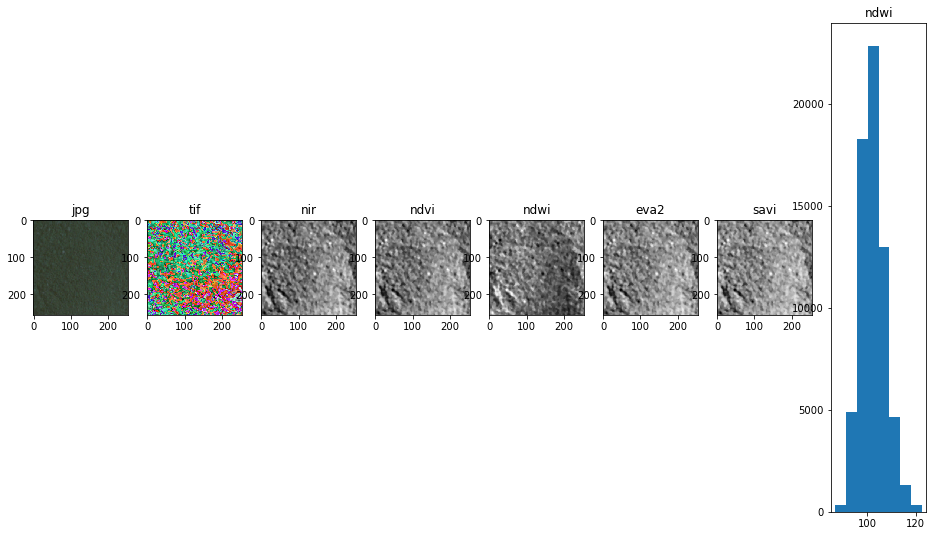

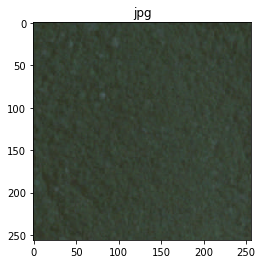

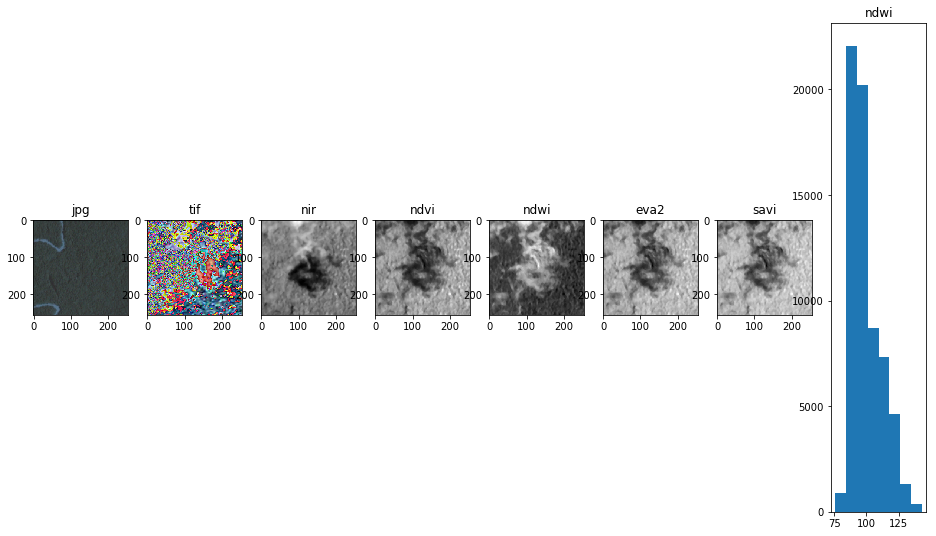

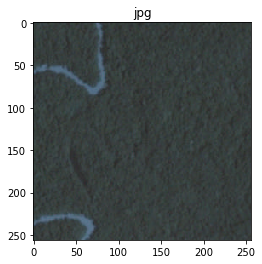

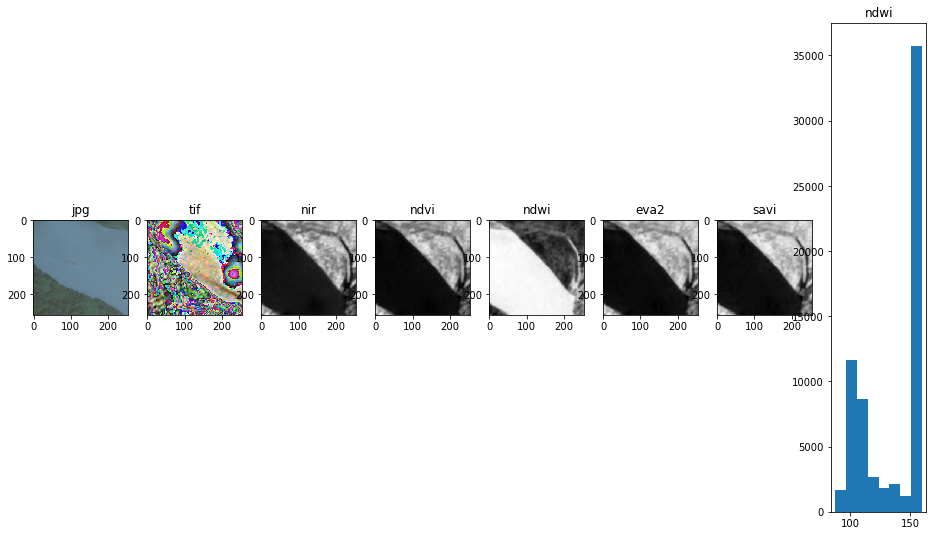

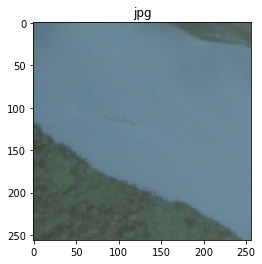

In [339]:
#labels_df.head(12)
sshow(jpg4fno[2])
sshow(jpg4f[6])
sshow(jpg4fyes[5])

In [338]:
def sshow(nn) :
    ijpg = cv.imread(os.path.join(trDirJPG,nn+'.jpg'),-1)
    itif = cv.imread(os.path.join(trDirTIF,nn+'.tif'),-1); itif.shape
    itif = cv.GaussianBlur(itif,(3,3),0); 
    itif = cv.medianBlur(itif,5)
    r,g,b,n = itif[:,:,2],itif[:,:,1],itif[:,:,0],itif[:,:,3]
    
    plt.figure(figsize=(16, 9));

    plt.subplot(181);plt.imshow(ijpg);plt.title('jpg')
    ndvi = np.divide((np.array(n,dtype=np.float32)-r),(g+r))
    ndwi = (np.divide((np.array(g,dtype=np.float32)-n),(g+n))+1.0)/2*256
    evi2 = 2.5*np.divide((np.array(n,dtype=np.float32)-r),(n+2.4*r+1.0))
    savi = 1.5*np.divide((np.array(n,dtype=np.float32)-r),(n+r+0.5))
    tif  = np.array([r,g,b]).T; tif=cv.GaussianBlur(tif,(3,3),0)
    plt.subplot(182);plt.imshow(tif);plt.title('tif')
    plt.subplot(183);plt.imshow(itif[:,:,3],'gray');plt.title('nir')
    plt.subplot(184);plt.imshow(ndvi,'gray');plt.title('ndvi')
    plt.subplot(185);plt.imshow(ndwi,'gray');plt.title('ndwi')
    plt.subplot(186);plt.imshow(evi2,'gray');plt.title('eva2')
    plt.subplot(187);plt.imshow(savi,'gray');plt.title('savi')
    plt.subplot(188);plt.hist(ndwi.ravel(),bins=8); plt.title('ndwi')
    plt.show()
    plt.imshow(ijpg);plt.title('jpg'); plt.show()

33068 25398
7411 7261
40479 38993
40479 7418


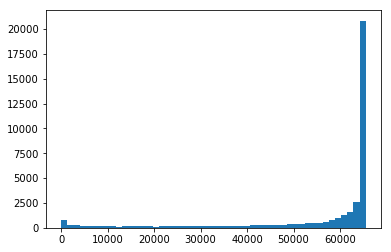

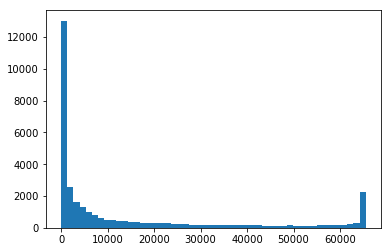

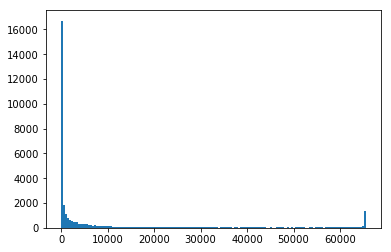

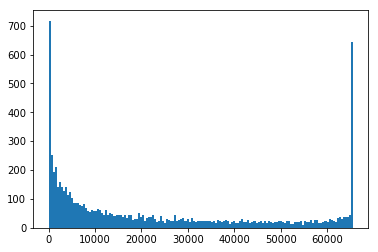

In [321]:
trX.shape
ii=7
ndwi0=trX[:,ii*256:ii*256+128].sum(axis=1)
ndwi1=trX[:,ii*256+128:ii*256+256].sum(axis=1)
ndwiY0=trX[trY[:,4]==0,ii*256+128:ii*256+256].sum(axis=1)
ndwiY1=trX[trY[:,4]==1,ii*256+128:ii*256+256].sum(axis=1)

print(len(ndwiY0),len(ndwiY0[ndwiY0>0]))
print(len(ndwiY1),len(ndwiY1[ndwiY1>0]))

print(len(ndwi0),len(ndwi0[ndwi0>0]))
print(len(ndwi1),len(ndwi1[ndwi1>25000]))
plt.hist(ndwi0[ndwi0>0],bins=50); plt.show()
plt.hist(ndwi1[ndwi1>0],bins=50); plt.show()
plt.hist(ndwiY0,bins=150); plt.show()
plt.hist(ndwiY1,bins=150); plt.show()

In [363]:
rr = np.array([True]*trY.shape[0])
for x in [4,5,6,7] :
    xx=trY[:,x]<>trY01[:,x]
    rr=np.logical_and(rr,xx)
    
print(len(rr[rr]))
bad_bad_names  = np.array(nameList)[rr]; bad_bad_names[:10]
bad_bad_labels = labels_df[rr]


#y1=np.logical_and((trY[:,4]==trY01[:,4]),(trY[:,4]==1))
#y0=np.logical_and((trY[:,4]==trY01[:,4]),(trY[:,4]==0))
#jpg4f=np.array(nameList)[xx]
#jpg4l=np.array(nameList)[xx]


3


        image_name                                               tags
5026    train_5026  agriculture clear cultivation habitation prima...
23952  train_23952  agriculture cultivation cultivation habitation...
24607  train_24607                clear habitation primary road water


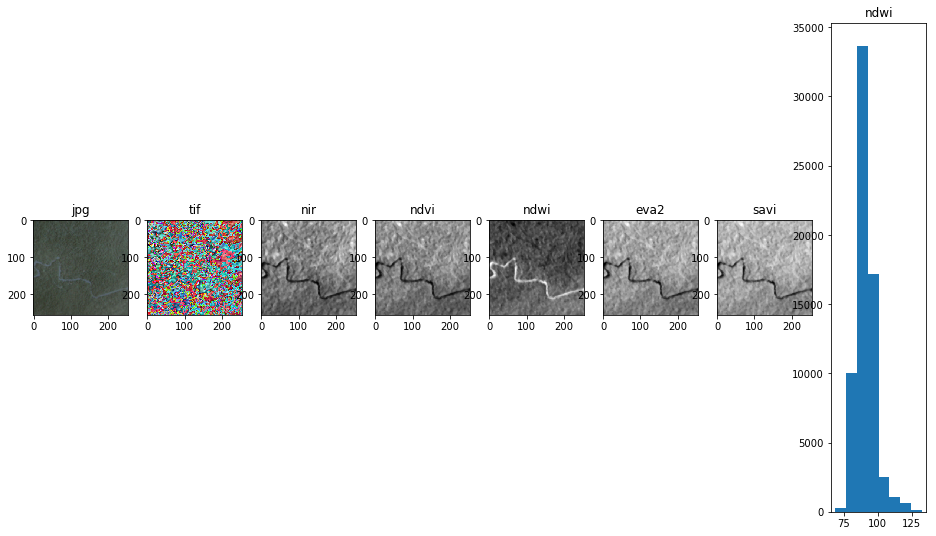

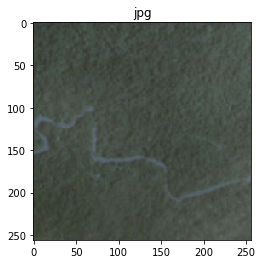

In [366]:
print(bad_bad_labels[['image_name','tags']].head())
sshow(bad_bad_names[2])
